# Data Processing 
Objective: Test preprocessing script 

## 1. Setup and imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys
import os

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from src.data.preprocessor import SolarForecastingPreprocessor

## 2. Create Preprocessor Instance

In [3]:
# Initialize with time series parameters
preprocessor = SolarForecastingPreprocessor(
    forecast_horizon=24,
    lag_days=[1, 2, 3, 7, 30],
    rolling_windows=[7, 30],
    scaling_method='standard'
)

INFO:src.data.preprocessor:Initialized SolarForecastingPreprocessor: horizon=24h, lags=[1, 2, 3, 7, 30] days, rolling_windows=[7, 30] days, scaling=standard


In [4]:
print(f"Preprocessor fitted: {preprocessor.is_fitted}")
print(f"Forecast horizon: {preprocessor.forecast_horizon} hours")
print(f"Lag days: {preprocessor.lag_days}")
print(f"Rolling windows: {preprocessor.rolling_windows} days")

Preprocessor fitted: False
Forecast horizon: 24 hours
Lag days: [1, 2, 3, 7, 30]
Rolling windows: [7, 30] days


## 3. Load and Validate Data

In [5]:
# Load data (no weather data used in features!)
df, load_metadata = preprocessor.load_and_prepare_data(
    "../data/raw/Plant_1_Generation_Data.csv",
    "../data/raw/Plant_1_Weather_Sensor_Data.csv"  # Only for validation
)

print(f"Data loaded: {df.shape}")
print(f"Date range: {load_metadata['date_range']['start']} to {load_metadata['date_range']['end']}")
print(f"Total days: {load_metadata['total_days']}")

INFO:src.data.preprocessor:Loading solar generation data...
INFO:src.data.preprocessor:Resampling to hourly frequency...
INFO:src.data.preprocessor:Removed 20 NaN rows after resampling
INFO:src.data.preprocessor:Data loaded successfully: 796 records from 2020-05-15 00:00:00 to 2020-06-17 23:00:00


Data loaded: (796, 2)
Date range: 2020-05-15 00:00:00 to 2020-06-17 23:00:00
Total days: 33


## 4. Validate Forecasting Setup

In [6]:
# CRITICAL: Check for data leakage
validation_report = preprocessor.validate_forecasting_setup(df)

print(f"Validation Status: {'PASSED' if validation_report['overall_valid'] else '❌ FAILED'}")
print(f"No weather leakage: {validation_report['leakage_checks']['no_contemporary_weather']}")
print(f"Sufficient history: {validation_report['temporal_validation']['sufficient_history']}")
print(f"Data quality score: {validation_report['data_quality']['temporal_gaps']['total_gaps']} gaps")

INFO:src.data.preprocessor:Validating forecasting setup for data leakage...
INFO:src.data.preprocessor:✅ Forecasting setup validation PASSED


Validation Status: PASSED
No weather leakage: True
Sufficient history: True
Data quality score: 4 gaps


## 5. Create Forecasting Dataset (Fit Transform)

In [7]:
# Create X (features) and y (24h targets)
X, y, metadata = preprocessor.fit_transform(
    "../data/raw/Plant_1_Generation_Data.csv",
    "../data/raw/Plant_1_Weather_Sensor_Data.csv"
)

print(f"Features (X) shape: {X.shape}")
print(f"Targets (y) shape: {y.shape}")
print(f"Preprocessor fitted: {preprocessor.is_fitted}")

INFO:src.data.preprocessor:Starting complete forecasting preprocessing pipeline...
INFO:src.data.preprocessor:Loading solar generation data...
INFO:src.data.preprocessor:Resampling to hourly frequency...
INFO:src.data.preprocessor:Removed 20 NaN rows after resampling
INFO:src.data.preprocessor:Data loaded successfully: 796 records from 2020-05-15 00:00:00 to 2020-06-17 23:00:00
INFO:src.data.preprocessor:Validating forecasting setup for data leakage...
INFO:src.data.preprocessor:✅ Forecasting setup validation PASSED
INFO:src.data.preprocessor:Creating forecasting dataset...
INFO:src.data.preprocessor:Creating historical lag features...
INFO:src.data.preprocessor:Created 5 lag features and 2 rolling features
INFO:src.data.preprocessor:Creating temporal features for future dates...
INFO:src.data.preprocessor:Created 16 temporal features
INFO:src.data.preprocessor:Forecasting dataset created: X shape (52, 32), y shape (52, 24)
INFO:src.data.preprocessor:Removed 744 rows with missing value

Features (X) shape: (52, 32)
Targets (y) shape: (52, 24)
Preprocessor fitted: True


In [8]:
preprocessor.is_fitted

True

## 6. Analyze Features and Targets

In [9]:
# Feature analysis
print("FEATURE ANALYSIS:")
print(f"Total features: {len(preprocessor.get_feature_names())}")
print(f"Lag features: {metadata['feature_info']['lag_features']}")
print(f"Rolling features: {metadata['feature_info']['rolling_features']}")
print(f"Temporal features: {metadata['feature_info']['temporal_features']}")

FEATURE ANALYSIS:
Total features: 31
Lag features: 5
Rolling features: 6
Temporal features: 16


In [10]:
# Feature names (NO WEATHER FEATURES)
feature_names = preprocessor.get_feature_names()
print("\nFEATURE NAMES:")
for i, name in enumerate(feature_names):
    print(f"  {i+1:2d}. {name}")


FEATURE NAMES:
   1. ac_power_lag_1d
   2. ac_power_lag_2d
   3. ac_power_lag_3d
   4. ac_power_lag_7d
   5. ac_power_lag_30d
   6. rolling_mean_7d
   7. rolling_std_7d
   8. rolling_max_7d
   9. rolling_mean_30d
  10. rolling_std_30d
  11. rolling_max_30d
  12. same_hour_last_week
  13. same_hour_2_weeks_ago
  14. same_weekday_last_week
  15. hour_of_day
  16. day_of_week
  17. day_of_year
  18. month
  19. quarter
  20. is_daylight
  21. is_peak_solar
  22. is_weekend
  23. hour_sin
  24. hour_cos
  25. day_of_year_sin
  26. day_of_year_cos
  27. day_of_week_sin
  28. day_of_week_cos
  29. solar_elevation_proxy
  30. season_spring
  31. season_summer


In [11]:
# Target analysis
print("\nTARGET ANALYSIS:")
print(f"Target columns: {list(y.columns)[:5]}...{list(y.columns)[-2:]}")
print(f"Target value range: {y.min().min():.2f} to {y.max().max():.2f}")
print(f"Target mean: {y.mean().mean():.2f}")


TARGET ANALYSIS:
Target columns: ['ac_power_1h', 'ac_power_2h', 'ac_power_3h', 'ac_power_4h', 'ac_power_5h']...['ac_power_23h', 'ac_power_24h']
Target value range: 0.00 to 1091.99
Target mean: 261.04


## 7. Sample Data Inspection

In [12]:
# Show sample features (first few rows and columns)
print("SAMPLE FEATURES (X):")
display_cols = ['DATE_TIME'] + feature_names[:8]
print(X[display_cols].head())

SAMPLE FEATURES (X):
            DATE_TIME  ac_power_lag_1d  ac_power_lag_2d  ac_power_lag_3d  \
0 2020-06-14 20:00:00        -0.761891        -0.747554        -0.722733   
1 2020-06-14 21:00:00        -0.761891        -0.747554        -0.722733   
2 2020-06-14 22:00:00        -0.761891        -0.747554        -0.722733   
3 2020-06-14 23:00:00        -0.761891        -0.747554        -0.722733   
4 2020-06-15 00:00:00        -0.761891        -0.747554        -0.722733   

   ac_power_lag_7d  ac_power_lag_30d  rolling_mean_7d  rolling_std_7d  \
0         -0.77129         -0.758475         0.919519        1.018861   
1         -0.77129         -0.758475         0.919519        1.018861   
2         -0.77129         -0.758475         0.919519        1.018861   
3         -0.77129         -0.758475         0.919519        1.018861   
4         -0.77129         -0.758475         0.919519        1.018861   

   rolling_max_7d  
0    2.273737e-13  
1    2.273737e-13  
2    2.273737e-13  
3  

In [13]:
# Show sample targets (first few rows and hours)
print("\nSAMPLE TARGETS (y) - First 5 prediction hours:")
target_cols = [f'ac_power_{h}h' for h in range(1, 6)]
print(y[target_cols].head())


SAMPLE TARGETS (y) - First 5 prediction hours:
   ac_power_1h  ac_power_2h  ac_power_3h  ac_power_4h  ac_power_5h
0          0.0          0.0          0.0          0.0          0.0
1          0.0          0.0          0.0          0.0          0.0
2          0.0          0.0          0.0          0.0          0.0
3          0.0          0.0          0.0          0.0          0.0
4          0.0          0.0          0.0          0.0          0.0


## 8. Test Midnight Prediction (Operational Mode)

In [14]:
# Test operational midnight prediction
test_date = "2020-06-10"  # Pick a date in the middle of our data

try:
    midnight_features = preprocessor.prepare_midnight_prediction(df, test_date)
    print(f"MIDNIGHT PREDICTION TEST:")
    print(f"   Prediction date: {test_date}")
    print(f"   Features shape: {midnight_features.shape}")
    print(f"   Feature timestamp: {midnight_features['DATE_TIME'].iloc[0]}")
    print(f"   Operational mode: READY")
except Exception as e:
    print(f"❌ Midnight prediction failed: {e}")

INFO:src.data.preprocessor:Preparing midnight prediction for 2020-06-10
INFO:src.data.preprocessor:Creating historical lag features...
INFO:src.data.preprocessor:Created 5 lag features and 2 rolling features
INFO:src.data.preprocessor:Creating temporal features for future dates...
INFO:src.data.preprocessor:Created 16 temporal features
INFO:src.data.preprocessor:Midnight prediction features prepared: (2, 32)


MIDNIGHT PREDICTION TEST:
   Prediction date: 2020-06-10
   Features shape: (2, 32)
   Feature timestamp: 2020-06-09 23:00:00
   Operational mode: READY


## 9. Data Leakage Verification

In [15]:
# Final verification: NO FORBIDDEN FEATURES
forbidden_features = [
    'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION',
    'temp_difference', 'temp_ratio', 'irradiation_per_temp',
    'power_efficiency', 'temp_irradiation_interaction'
]

forbidden_found = [f for f in forbidden_features if f in feature_names]

print(f"DATA LEAKAGE CHECK:")
print(f"   Forbidden features found: {len(forbidden_found)}")
if forbidden_found:
    print(f"   LEAKAGE DETECTED: {forbidden_found}")
else:
    print(f"   NO LEAKAGE: All features are historical/temporal only")

DATA LEAKAGE CHECK:
   Forbidden features found: 0
   NO LEAKAGE: All features are historical/temporal only


## 10. Test Save and Load

In [16]:
# Save fitted preprocessor
preprocessor.save_preprocessor('solar_forecasting_preprocessor.pkl')
print("Preprocessor saved")

INFO:src.data.preprocessor:Preprocessor saved to: solar_forecasting_preprocessor.pkl


Preprocessor saved


In [17]:
# Load and verify
loaded_preprocessor = SolarForecastingPreprocessor.load_preprocessor('solar_forecasting_preprocessor.pkl')
print(f"Preprocessor loaded: fitted={loaded_preprocessor.is_fitted}")
print(f"   Features count: {len(loaded_preprocessor.get_feature_names())}")
print(f"   Forecast horizon: {loaded_preprocessor.forecast_horizon}h")

INFO:src.data.preprocessor:Preprocessor loaded from: solar_forecasting_preprocessor.pkl


Preprocessor loaded: fitted=True
   Features count: 31
   Forecast horizon: 24h


## 11. Quick Data Visualization 

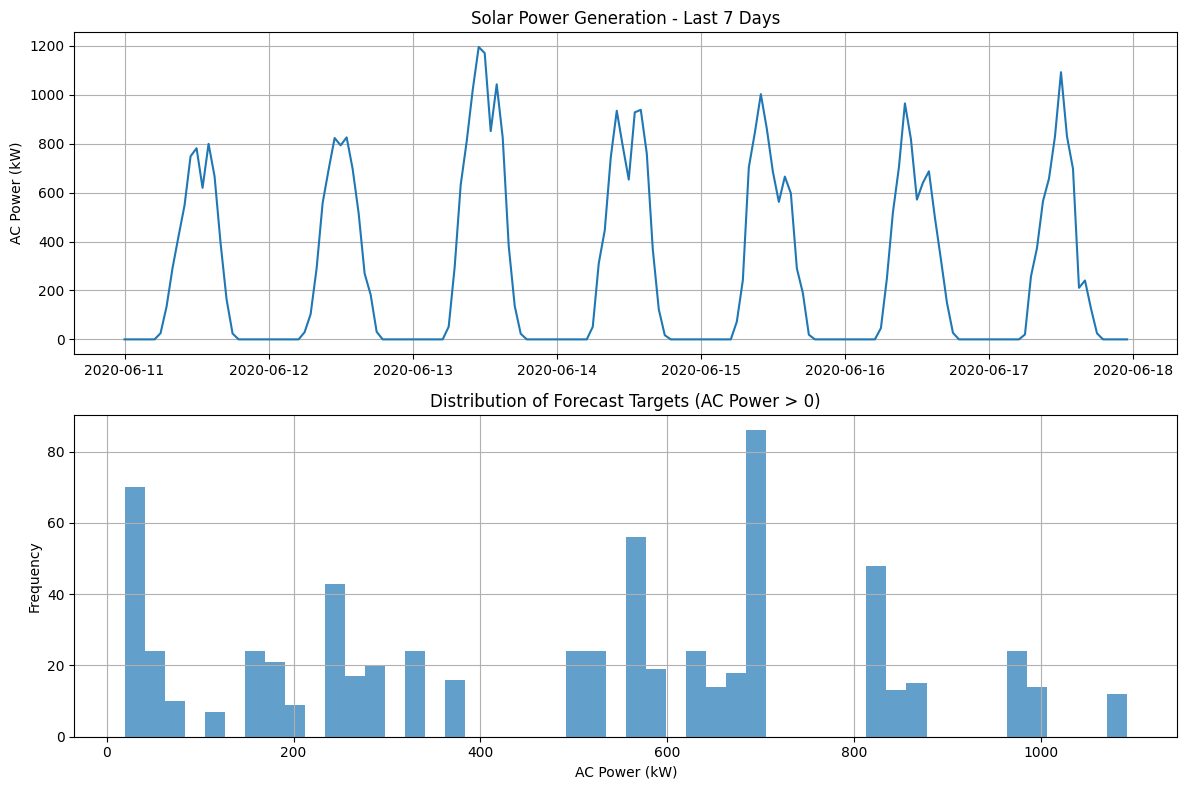

In [18]:
import matplotlib.pyplot as plt

# Plot sample AC_POWER time series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Original time series (last 7 days)
last_week = df.tail(7*24)
ax1.plot(last_week['DATE_TIME'], last_week['AC_POWER'])
ax1.set_title('Solar Power Generation - Last 7 Days')
ax1.set_ylabel('AC Power (kW)')
ax1.grid(True)

# Target distribution (all forecast hours)
y_flat = y.values.flatten()
ax2.hist(y_flat[y_flat > 0], bins=50, alpha=0.7)
ax2.set_title('Distribution of Forecast Targets (AC Power > 0)')
ax2.set_xlabel('AC Power (kW)')
ax2.set_ylabel('Frequency')
ax2.grid(True)

plt.tight_layout()
plt.show()